In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
import illustris_python as il
import h5py
import os
import pickle

In [2]:
basepaths = {'TNG100': ['/virgotng/universe/IllustrisTNG/TNG100-1/output',99],
            'SIMBA': ['/virgotng/universe/Simba/L100n1024FP/output',151],
            'EAGLE': ['/virgotng/universe/Eagle/Eagle100-1/output',28],
            'TNG100-2': ['/virgotng/universe/IllustrisTNG/TNG100-2/output',99],
            'TNG100-3': ['/virgotng/universe/IllustrisTNG/TNG100-3/output',99]}

In [3]:
def shift(u, v, box_length):
    """
    returns the position vector u-v in a periodic Cartesian box
    
    Parameters
    ----------
    u : N x 3 position array
    v : N x 3 OR 1 x 3 position array
    box_length : float in same units as [u], [v]
    
    Returns
    -------
    result: N x M position vector (array)
    """

    result = u - v
    result[result > box_length / 2.0] -= box_length
    result[result < -box_length / 2.0] += box_length
    
    return result



def floor_to_value(number,roundto):
    """
    returns the round-down of number to the nearest roundto
    """
    
    return (np.floor(number / roundto) * roundto)



def ceil_to_value(number,roundto):
    """
    returns the round-up of number to the nearest roundto
    """

    return (np.ceil(number / roundto) * roundto)



def logbin(x, binwidth):
    '''returns the logbins of (x) with the given binwidth
       input x is an array with min and max values'''

    bin_max = ceil_to_value(np.log10(max(x)), binwidth)
    bin_min = floor_to_value(np.log10(min(x)), binwidth)

    nbins = int(round((bin_max - bin_min) / binwidth)) + 1

    logbins = np.logspace(bin_min, bin_max, nbins)
    bincents = 10**((np.log10(logbins)[1:]+np.log10(logbins[:-1]))/2)
    
    return logbins, bincents



def mass_mask(basepath, snapshot, cutmin = 10**12.5 , cutmax = 10**14.3):
    '''
    takes the basepath and snapshot number as inputs for a sim
    and applies a mask in Group_M_Crit200
    '''
    
    # Loading header
    header = il.groupcat.loadHeader(basepath, snapshot)
    h = header['HubbleParam']
    a = header['Time']

    # Loading halo data
    M200c = il.groupcat.loadHalos(basepath, snapshot, fields=['Group_M_Crit200']) * 10**10 / h  # Msun
    
    # Apply mass cut
    haloIDs = np.where((M200c > cutmin) & (M200c < cutmax))[0]
    M200c = M200c[haloIDs]
        
    return M200c, haloIDs

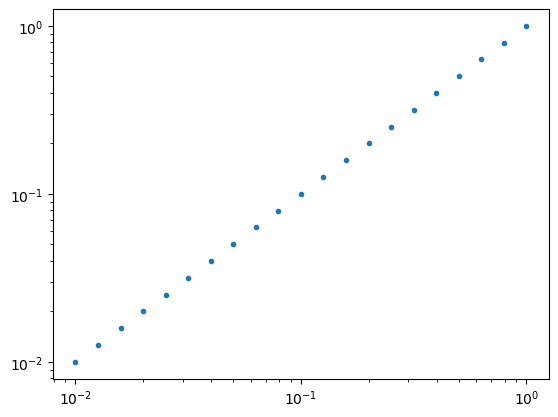

In [8]:
plt.loglog(logbin([10**-2,1], 0.1)[0], logbin([10**-2,1], 0.1)[0], '.')

In [35]:
def radial_profile_dict(sim_dict, r200c = False):
    """
    takes in dict{ 'sim name': [baspeath,snapnum] } and returns
    nested dict1{ 'sim name': dict2{ 'halo id': dict3{ 'field': value array} } }
    
    if r200c is true, normalises radial bins by r_crit200, if false, normalises by r_crit500 
    
    """
    
    # initialise output dictionary
    result = {}
    
    #loop for each sim
    for sim, basepath in sim_dict.items():
        
        # load header
        header = il.groupcat.loadHeader(basepath[0], basepath[1])
        h = header['HubbleParam']
        a = header['Time']
        BoxSize = header['BoxSize'] * a / h # pkpc
        
        # define dm mass for each sim box
        if sim == 'TNG100':
            dm_mass = 0.000505574296436975 *10**10/h, # Msun
        elif sim == 'SIMBA' :
            dm_mass = 9.6*10**7, # Msun
        elif sim == 'EAGLE' : 
            dm_mass = 9.70*10**6 # Msun
        elif sim == 'TNG100-2':
            dm_mass = 0.0040445943714958 *10**10/h, # Msun
        elif sim == 'TNG100-3':
            dm_mass = 0.0323567549719664 *10**10/h, # Msun
        
        # load the group catalog to access the halo's position, r500c, m500c, etc.
        halo_fields = ['GroupPos', 'Group_R_Crit500', 'Group_R_Crit200']
        halos = il.groupcat.loadHalos(basepath[0] , basepath[1] , fields=halo_fields)
        
        GroupPos = halos['GroupPos'] * a / h # pkpc
        Group_R_Crit500 = halos['Group_R_Crit500'] * a/h # pkpc
        Group_R_Crit200 = halos['Group_R_Crit200'] * a/h # pkpc
        #Group_M_Crit200 = halos['Group_M_Crit200'] *10**10/h # Msun
        
        # loading the mass masked halo Ids
        group_masses, haloIDs = mass_mask(basepath[0], basepath[1], cutmin=10**13, cutmax=10**14) 
        
        # create log bins
        radii_bins_norm, radii_bincents_norm = logbin([10**-2,1], 0.1) # (0.01 to 1) group_r_crit in width of 0.1 logbins 

        # prepend 0 to the radial bins to capture the center of the sphere
        radii_bins_norm     = np.insert(radii_bins_norm, 0, 0.)
        radii_bincents_norm = np.insert(radii_bincents_norm, 0, radii_bins_norm[1]/2.)
        
        # store the profiles in a dictionary, the result dictionary will take haloIDs as keys, leading to a new dictionary
        # each halo's dictionary will hold datasets related to the gas fraction within the shells
        result[sim] = {}
        dset_keys = ['phys_radii', 'norm_radii', 'gas_mass_in_bins', 'star_mass_in_bins', 'bh_mass_in_bins', 'tot_mass_in_bins', 'gas_mass_in_bins_cumulative', 'star_mass_in_bins_cumulative', 'bh_mass_in_bins_cumulative', 'tot_mass_in_bins_cumulative']
        
        # loop for each halo
        for index, haloID in enumerate(haloIDs):
            
            #initialise the dict where data for each halo will be stored
            halo_key = f'{haloID}'
            result[sim][halo_key] = {}

            grouppos = GroupPos[haloID]
            
            # choose normalisation radius
            if r200c:
                group_r_crit = Group_R_Crit200[haloID]
            else:
                group_r_crit = Group_R_Crit500[haloID]       

        
            #load the halo particles
            gas_fields = ['Coordinates', 'Masses']
            gashalo =  il.snapshot.loadHalo(basepath[0] , basepath[1] , haloID , 0 , fields = gas_fields)
            gas_coordinates = gashalo['Coordinates'] * a/h # pkpc
            gas_masses = gashalo['Masses'] * 10**10/h # Msun
            
            dm_fields = ['Coordinates']
            dm_coordinates = il.snapshot.loadHalo(basepath[0] , basepath[1] , haloID , 1 , fields = dm_fields) * a/h # pkpc
            dm_masses = np.ones(len(dm_coordinates), dtype=type(dm_mass)) * dm_mass # Msun
            
            star_fields = ['Coordinates', 'Masses']
            starhalo = il.snapshot.loadHalo(basepath[0] , basepath[1] , haloID , 4 , fields = star_fields)
            star_coordinates = starhalo['Coordinates'] * a/h # pkpc
            star_masses = starhalo['Masses'] * 10**10/h # Msun
            
            bh_fields = ['Coordinates', 'BH_Mass']
            bhhalo = il.snapshot.loadHalo(basepath[0] , basepath[1] , haloID , 5 , fields = bh_fields)
            bh_coordinates = bhhalo['Coordinates'] * a/h # pkpc
            bh_masses = bhhalo['BH_Mass'] * 10**10/h # Msun


            #center the dm coordinates on the halo's center and calculate the radius, including periodic boundary conditions
            gas_rad = shift(gas_coordinates, grouppos, BoxSize) # pkpc
            gas_radii = np.linalg.norm(gas_rad, axis =1)
            
            dm_rad = shift(dm_coordinates, grouppos, BoxSize) # pkpc
            dm_radii = np.linalg.norm(dm_rad, axis =1)
            
            star_rad = shift(star_coordinates, grouppos, BoxSize) # pkpc
            star_radii = np.linalg.norm(star_rad, axis =1)
            
            bh_rad = shift(bh_coordinates, grouppos, BoxSize) # pkpc
            bh_radii = np.linalg.norm(bh_rad, axis =1)
            

            # convert the bins to physical units
            radii_bins_phys = radii_bins_norm * group_r_crit # pkpc
            radii_bincents_phys = radii_bincents_norm * group_r_crit # pkpc
            
            # calculate the gas fraction in bins           
            # make histograms for each particletype and then get the mass fraction of gas
            gas_mass_in_bins  = np.histogram(gas_radii, bins = radii_bins_phys, weights = gas_masses)[0]
            dm_mass_in_bins = np.histogram(dm_radii, bins = radii_bins_phys, weights = dm_masses)[0]
            star_mass_in_bins = np.histogram(star_radii, bins = radii_bins_phys, weights = star_masses)[0]
            bh_mass_in_bins = np.histogram(bh_radii, bins = radii_bins_phys, weights = bh_masses)[0]
            
            tot_mass_in_bins = dm_mass_in_bins + gas_mass_in_bins + star_mass_in_bins + bh_mass_in_bins   
            #gas_frac_in_bins = gas_mass_in_bins / tot_mass_in_bins
            #norm_gas_frac = gas_frac_in_bins / 0.16    # normalised to the cosmic average baryon fraction
            
            # calculate cumulative mass
            gas_mass_in_bins_cumulative = np.cumsum(gas_mass_in_bins)
            tot_mass_in_bins_cumulative = np.cumsum(tot_mass_in_bins)
            star_mass_in_bins_cumulative = np.cumsum(star_mass_in_bins)
            bh_mass_in_bins_cumulative = np.cumsum(bh_mass_in_bins)
            #gas_frac_in_bins_cumulative = gas_mass_in_bins_cumulative / tot_mass_in_bins_cumulative
            #norm_gas_frac_cumulative = gas_frac_in_bins_cumulative / 0.16
            
            # check if empty bins occur
            if np.any(tot_mass_in_bins) == 0:
                print(haloID)

            # append the results to the result dictionary
            dsets = [radii_bins_phys, radii_bins_norm, gas_mass_in_bins, star_mass_in_bins, bh_mass_in_bins, tot_mass_in_bins, gas_mass_in_bins_cumulative, star_mass_in_bins_cumulative, bh_mass_in_bins_cumulative, tot_mass_in_bins_cumulative]
            for dset_index, dset_key in enumerate(dset_keys):
                result[sim][halo_key][dset_key] = dsets[dset_index]
        
    return result

In [36]:
with open('/vera/ptmp/gc/madepa/data/r200c_radial_data.pickle', 'wb') as f:
    pickle.dump(radial_profile_dict(basepaths, r200c=True), f)

In [7]:
def median_radial_profile(result):
    
    fig, ax = plt.subplots()
    
    for sim, result_dict in result.items():
        if sim in ('TNG100', 'SIMBA', 'EAGLE'):
            haloIDs = [key for key in result_dict.keys()]
            bincents = result_dict[haloIDs[0]]['norm_radii']

            # start an array to store the values of the gas fraction in each bin
            bin_array = np.ones( (len(haloIDs), len(bincents)) )


            for index, haloID in enumerate(haloIDs):
                halo_key = f'{haloID}'

                for i in range(len(bincents)):
                    bin_array[index, i] = ((result_dict[haloID]['gas_mass_in_bins_cumulative'][i] + result_dict[haloID]['star_mass_in_bins_cumulative'][i]) / result_dict[haloID]['tot_mass_in_bins_cumulative'][i]) / 0.16

            median = np.median(bin_array, axis=0)
            minimum = np.min(bin_array, axis =0)
            maximum = np.max(bin_array, axis=0)
            std = np.std(bin_array, axis=0)     

            ax.plot(bincents, median, '-', label = sim)
            ax.fill_between(bincents, median - std , median + std , alpha=0.1)
        
    
    ax.text(0.025, 0.75, 'FOF $ M _{200c}  $ $ = 10^{13} - 10^{14}$ $ M_\odot $', fontsize=8, transform=ax.transAxes)
    ax.set_ylabel('$f_g(<r) \;/\; f_{b,cosmic}$')
    ax.set_title('Gas fraction radial profile at z=0')

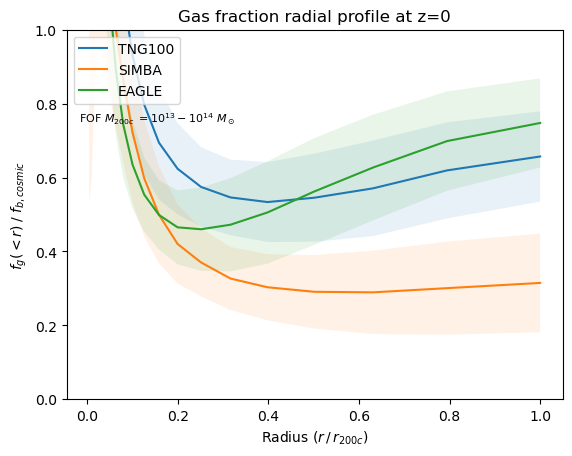

In [12]:
median_radial_profile(data_dict)
plt.xlabel('Radius $(r \,/\,r_{200c})$')
plt.legend(loc='upper left')
plt.ylim(0,1)
#plt.savefig('gas_prof_r200')
plt.show()

In [12]:
basepaths = {'TNG100': ['/virgotng/universe/IllustrisTNG/TNG100-1/output',99],
            'SIMBA': ['/virgotng/universe/Simba/L100n1024FP/output',151],
            'EAGLE': ['/virgotng/universe/Eagle/Eagle100-1/output',28],
            'TNG100-2': ['/virgotng/universe/IllustrisTNG/TNG100-2/output',99],
            'TNG100-3': ['/virgotng/universe/IllustrisTNG/TNG100-3/output',99]}

In [13]:
def mass_masking(basepath, snapshot, cutmin = 10**12.5 , cutmax = 10**14.3):
    '''
    takes the basepath and snapshot number as inputs for a sim
    and applies a mask in Group_M_Crit200
    '''
    
    # Loading header
    header = il.groupcat.loadHeader(basepath, snapshot)
    h = header['HubbleParam']

    # Loading halo data
    halos = il.groupcat.loadHalos(basepath, snapshot, fields=['Group_M_Crit200', 'Group_M_Crit500'])
    
    M200c = halos['Group_M_Crit200'] * 10**10 / h  # Msun
    M500c = halos['Group_M_Crit500'] * 10**10 / h  # Msun
    
    # Apply mass cut
    haloIDs = np.where((M200c > cutmin) & (M200c < cutmax))[0]
    M200c = M200c[haloIDs]
    M500c = M500c[haloIDs]
        
    return M200c, M500c, haloIDs

In [23]:
def mass_dict(sim_dict):
    
    # initialise output dictionary
    result = {}
    
    #loop for each sim
    for sim, basepath in sim_dict.items():
        
        if sim in ('TNG100', 'SIMBA', 'EAGLE'):
            
            # load header
            header = il.groupcat.loadHeader(basepath[0], basepath[1])
            h = header['HubbleParam']


            # loading the mass masked halo Ids and m200c, m500c
            M200c, M500c, haloIDs = mass_masking(basepath[0], basepath[1])

            # initialise the inner dict
            result[sim] = {}

            for index, haloID in enumerate (haloIDs):
                
                halo_key = f'{haloID}'
                # ini. the innermost dict
                result[sim][halo_key] = {}
                
                # append data to dict
                result[sim][halo_key]['M200c'] = np.log10(M200c[index])
                result[sim][halo_key]['M500c'] = np.log10(M500c[index])
                
    return result

In [24]:
#with open('../data/masses.pickle', 'wb') as f:
#    pickle.dump(mass_dict(basepaths),f)